<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: Юрий Исаков и Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>  Практика. Идентификация пользователя с помощью логистической регрессии

Тут мы воспроизведем парочку бенчмарков нашего соревнования и вдохновимся побить третий бенчмарк, а также остальных участников. Веб-формы для отправки ответов тут не будет, ориентир – [leaderboard](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard) соревнования.

In [37]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки и посмотрим на данные.

In [2]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


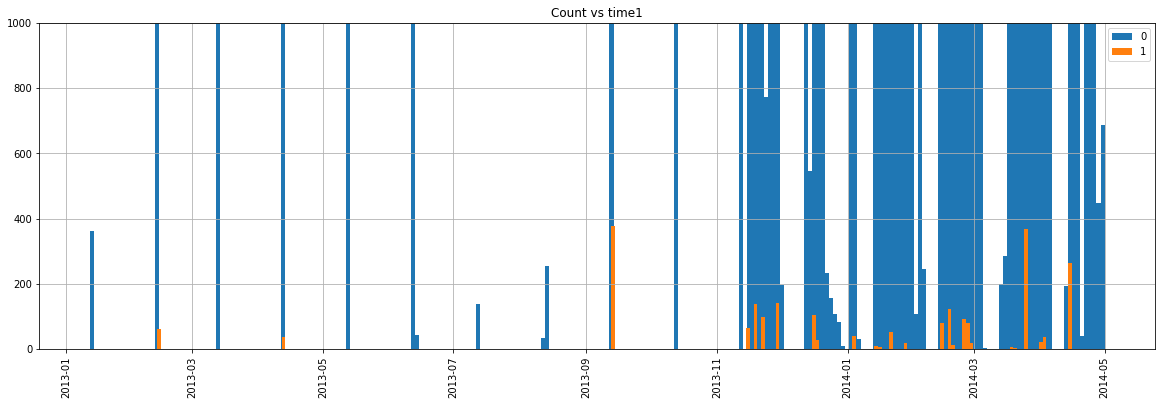

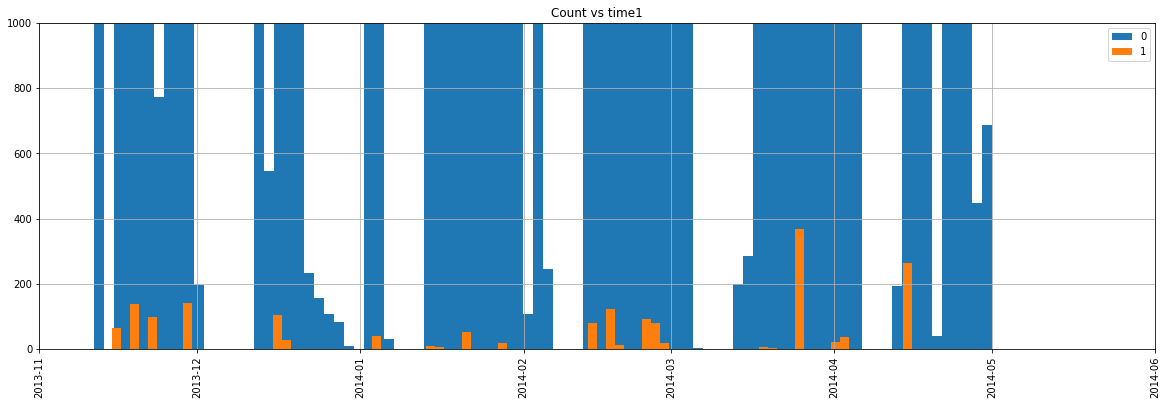

In [3]:
plt.figure(figsize=(20, 6))
plt.title("Count vs time1")
train_df[train_df['target'] == 0]['time1'].hist(bins=250, label='0')
train_df[train_df['target'] == 1]['time1'].hist(bins=250, label='1')
plt.xticks(rotation=90)
plt.ylim((0, 1000))
plt.legend()

plt.figure(figsize=(20, 6))
plt.title("Count vs time1")
train_df[train_df['target'] == 0]['time1'].hist(bins=250, label='0')
train_df[train_df['target'] == 1]['time1'].hist(bins=250, label='1')
plt.xticks(rotation=90)
plt.xlim(('2013-11', '2014-06'))
plt.ylim((0, 1000))
plt.legend()

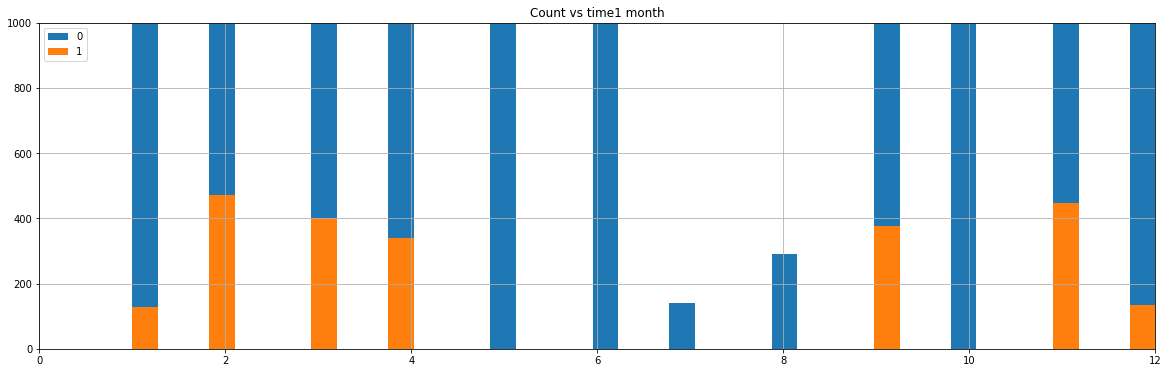

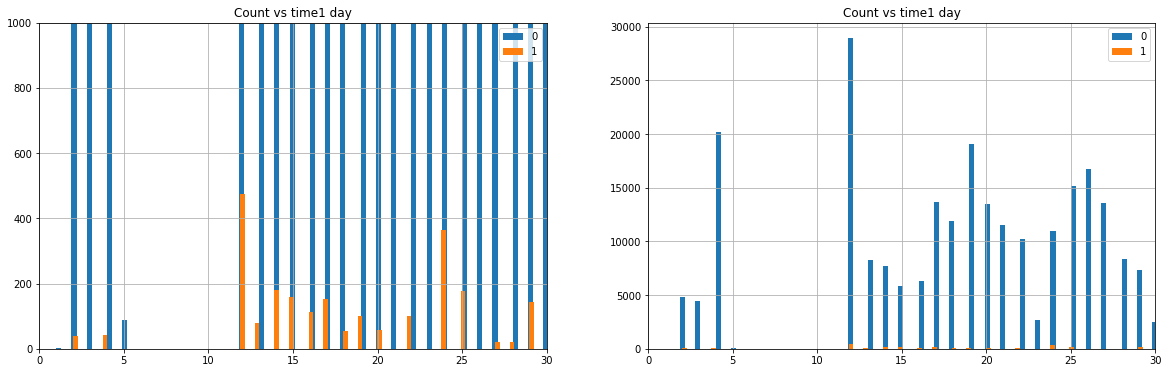

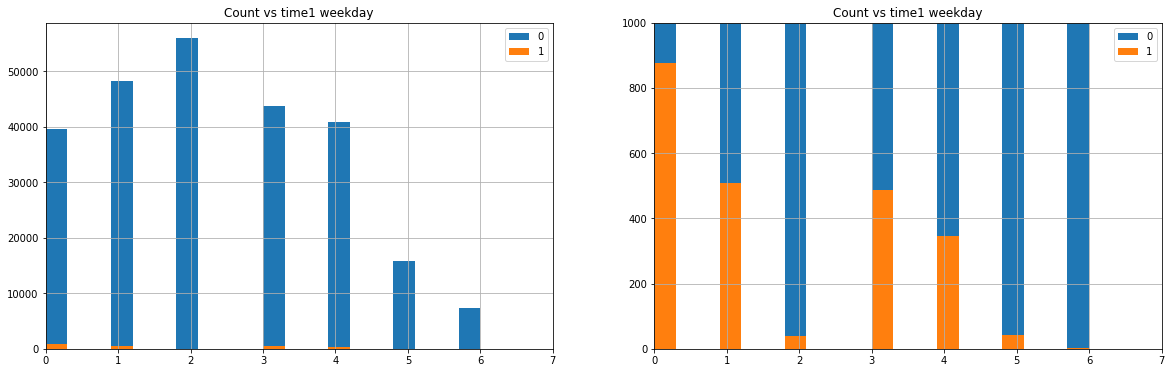

In [4]:
def to_month(x):
    return x.month

plt.figure(figsize=(20, 6))
plt.title("Count vs time1 month")
train_df[train_df['target'] == 0]['time1'].apply(to_month).hist(bins=40, label='0')
train_df[train_df['target'] == 1]['time1'].apply(to_month).hist(bins=40, label='1')
plt.ylim((0, 1000))
plt.xlim((0, 12))
plt.legend()


def to_day(x):
    return x.day

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.title("Count vs time1 day")
train_df[train_df['target'] == 0]['time1'].apply(to_day).hist(bins=100, label='0')
train_df[train_df['target'] == 1]['time1'].apply(to_day).hist(bins=100, label='1')
plt.ylim((0, 1000))
plt.xlim((0, 30))
plt.legend()

plt.subplot(122)
plt.title("Count vs time1 day")
train_df[train_df['target'] == 0]['time1'].apply(to_day).hist(bins=100, label='0')
train_df[train_df['target'] == 1]['time1'].apply(to_day).hist(bins=100, label='1')
plt.xlim((0, 30))
plt.legend()


def to_weekday(x):
    return x.weekday()

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.title("Count vs time1 weekday")
train_df[train_df['target'] == 0]['time1'].apply(to_weekday).hist(bins=20, label='0')
train_df[train_df['target'] == 1]['time1'].apply(to_weekday).hist(bins=20, label='1')
plt.xlim((0, 7))
plt.legend()
plt.subplot(122)
plt.title("Count vs time1 weekday")
train_df[train_df['target'] == 0]['time1'].apply(to_weekday).hist(bins=20, label='0')
train_df[train_df['target'] == 1]['time1'].apply(to_weekday).hist(bins=20, label='1')
plt.ylim((0, 1000))
plt.xlim((0, 7))
plt.legend()

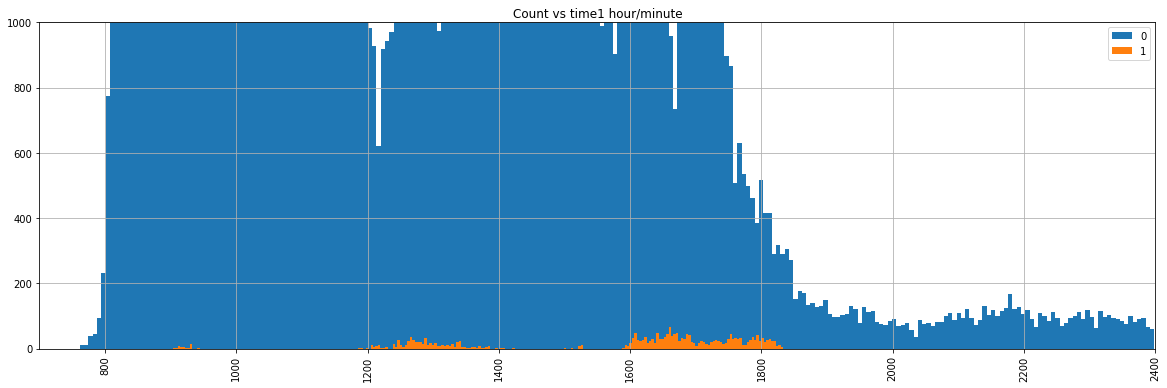

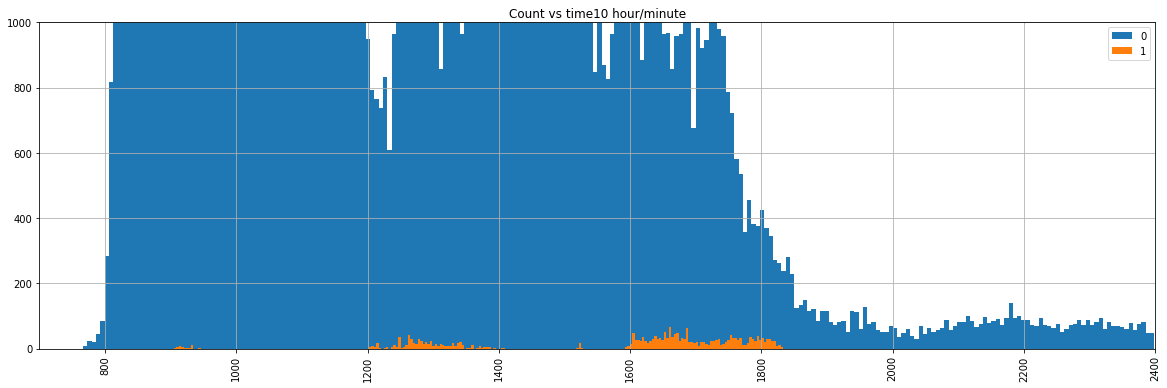

In [66]:
def to_hm(x):
    return x.hour * 100 + x.minute * 100.0 / 60.0

plt.figure(figsize=(20, 6))
plt.title("Count vs time1 hour/minute")
train_df[train_df['target'] == 0]['time1'].apply(to_hm).hist(bins=250, label='0')
train_df[train_df['target'] == 1]['time1'].apply(to_hm).hist(bins=250, label='1')
plt.xticks(rotation=90)
plt.ylim((0, 1000))
plt.xlim((700, 2400))
plt.legend()

plt.figure(figsize=(20, 6))
plt.title("Count vs time10 hour/minute")
train_df[train_df['target'] == 0]['time10'].apply(to_hm).hist(bins=250, label='0')
train_df[train_df['target'] == 1]['time10'].apply(to_hm).hist(bins=250, label='1')
plt.xticks(rotation=90)
plt.ylim((0, 1000))
plt.xlim((700, 2400))
plt.legend()

(0, 500)

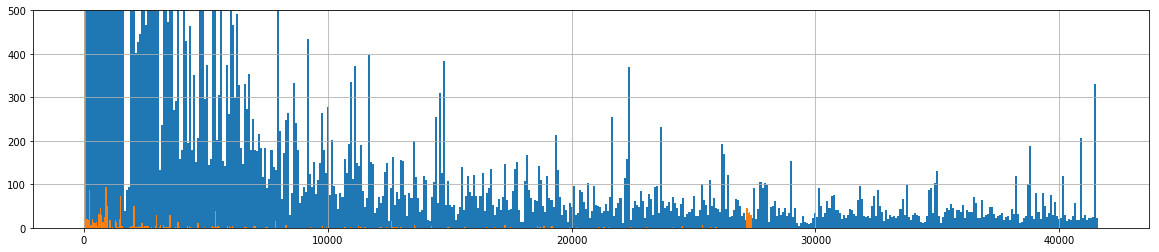

In [168]:
plt.figure(figsize=(20, 4))
train_df[train_df['target'] == 0]['site1'].hist(bins=500)
train_df[train_df['target'] == 1]['site1'].hist(bins=500)
plt.ylim((0, 500))

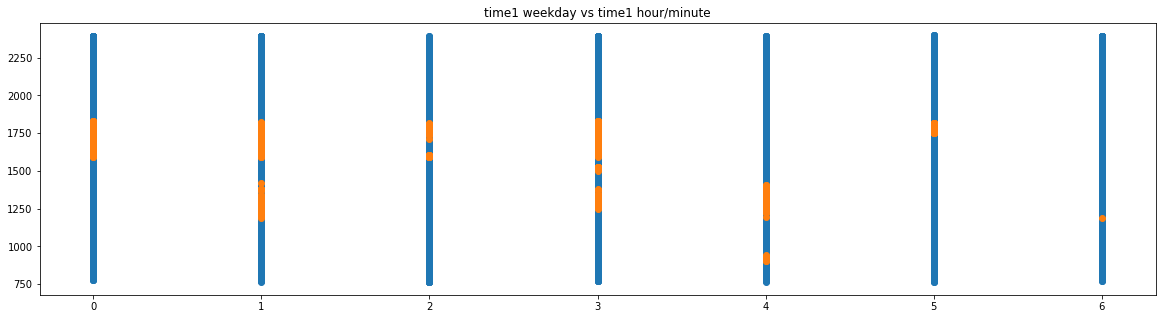

In [260]:
plt.figure(figsize=(20, 5))
plt.title("time1 weekday vs time1 hour/minute")
d01 = train_df[train_df['target'] == 0]['time1'].apply(to_weekday)
d02 = train_df[train_df['target'] == 0]['time1'].apply(to_hm)
plt.scatter(d01, d02, label='0')
d11 = train_df[train_df['target'] == 1]['time1'].apply(to_weekday)
d12 = train_df[train_df['target'] == 1]['time1'].apply(to_hm)
plt.scatter(d11, d12, label='1')

(0, 1000)

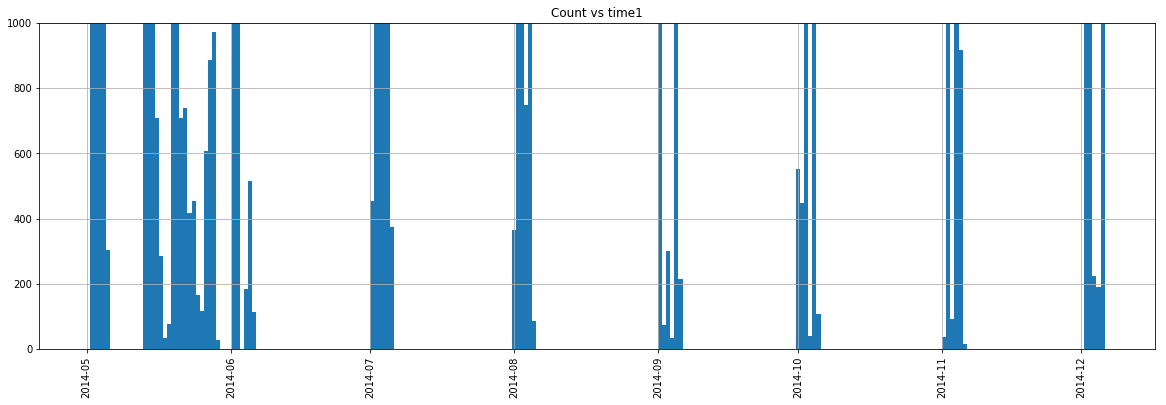

In [67]:
plt.figure(figsize=(20, 6))
plt.title("Count vs time1")
test_df['time1'].hist(bins=250)
plt.xticks(rotation=90)
plt.ylim((0, 1000))

(0, 7)

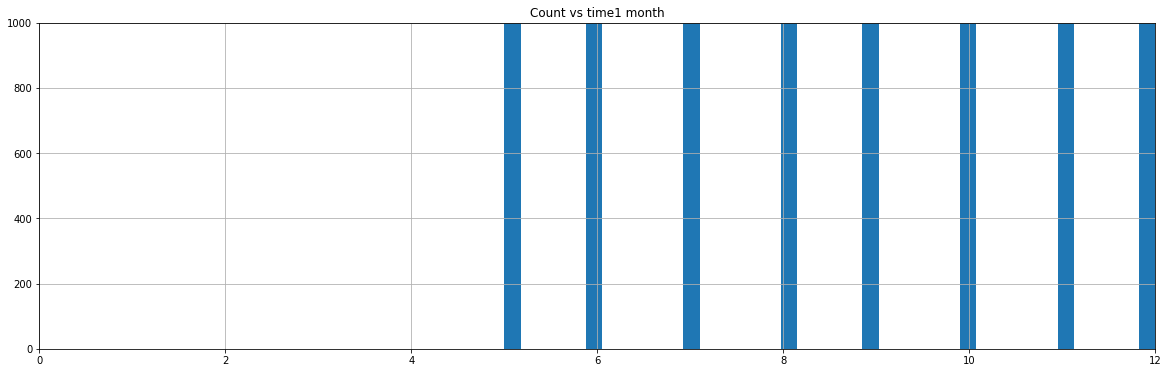

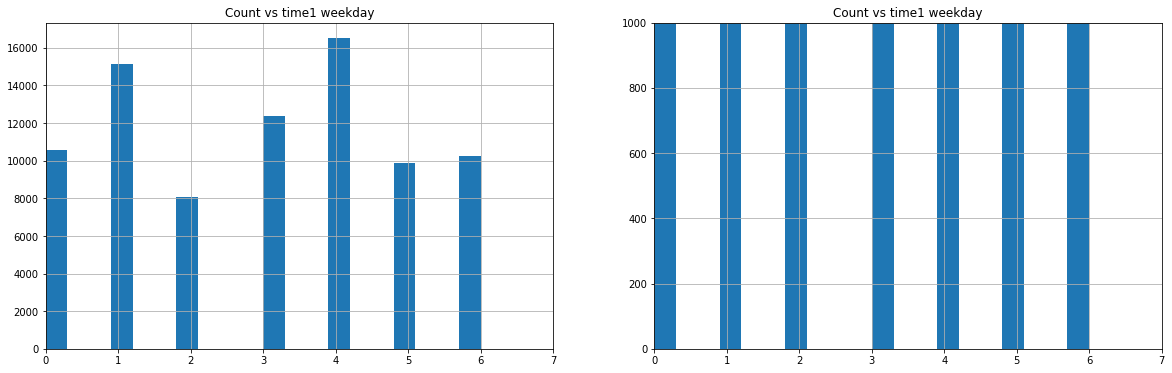

In [69]:
def to_month(x):
    return x.month

plt.figure(figsize=(20, 6))
plt.title("Count vs time1 month")
test_df['time1'].apply(to_month).hist(bins=40)
plt.ylim((0, 1000))
plt.xlim((0, 12))

def to_weekday(x):
    return x.weekday()

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.title("Count vs time1 weekday")
test_df['time1'].apply(to_weekday).hist(bins=20)
plt.xlim((0, 7))
plt.subplot(122)
plt.title("Count vs time1 weekday")
test_df['time1'].apply(to_weekday).hist(bins=20)
plt.ylim((0, 1000))
plt.xlim((0, 7))

(700, 2400)

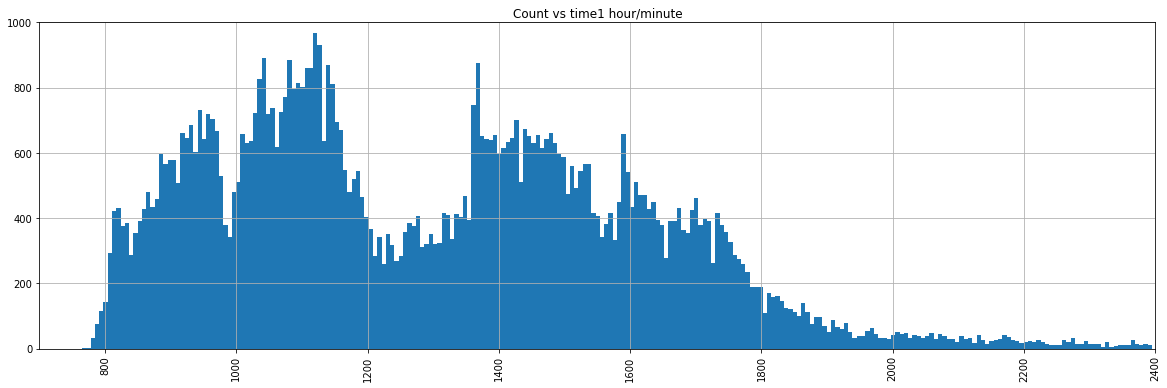

In [72]:
def to_hm(x):
    return x.hour * 100 + x.minute * 100.0 / 60.0

plt.figure(figsize=(20, 6))
plt.title("Count vs time1 hour/minute")
test_df['time1'].apply(to_hm).hist(bins=250)
plt.xticks(rotation=90)
plt.ylim((0, 1000))
plt.xlim((700, 2400))

В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [3]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])
print(u'всего сайтов:', sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
12748,www.actu-environnement.com
35462,news.harvard.edu
12738,a.lgds.eu
8588,www.jolpress.com
10942,thumbnails.eonline.com


Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [5]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

In [6]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


Для самой первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). За таким выбором данных для модели стоит такая идея:  *у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис и наоборот.*

Подготовим данные, из всей таблицы выберем только признаки `site1, site2, ... , site10`. Напомним, что пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:

In [7]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Сессии представляют собой последовательность индексов сайтов и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. Это делается в две строчки:

In [8]:
from scipy.sparse import csr_matrix

In [9]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

train_sites_sparse = full_sites_sparse[:idx_split, :]
test_sites_sparse = full_sites_sparse[idx_split:, :]

In [16]:
# train_df['sites_std'] = np.sum(train_sites_sparse[:, :] > 0, axis=1)
# train_df['sites_std2'] = np.sum(train_sites_sparse[:, :], axis=1)

# train_df[['sites_std', 'sites_std2', 'target']].corr()

Еще один плюс использования разреженных матриц в том, что для них имеются специальные реализации как матричных операций, так и алгоритмов машинного обучения, что подчас позволяет ощутимо ускорить операции за счет особенностей структуры данных. Это касается и логистической регрессии. Вот теперь у нас все готово для построения нашей первой модели.

### 2. Построение первой модели

Итак, у нас есть алгоритм и данные для него, построим нашу первую модель, воспользовавшись релизацией [логистической регрессии](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета `sklearn` с параметрами по умолчанию. Первые 90% данных будем использовать для обучения (обучающая выборка отсортирована по времени), а оставшиеся 10% для проверки качества (validation). 

**Напишите простую функцию, которая будет возвращать качество модели на отложенной выборке, и обучите наш первый классификатор**.

In [10]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(5)

for train_index, test_index in tscv.split(train_df):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

TRAIN: 42261 TEST: 42260
TRAIN: 84521 TEST: 42260
TRAIN: 126781 TEST: 42260
TRAIN: 169041 TEST: 42260
TRAIN: 211301 TEST: 42260


In [11]:
import os
os.environ['JOBLIB_TEMP_FOLDER']="/tmp"

In [16]:
from sklearn.metrics import roc_auc_score, recall_score


def train_test_split(X, y, ratio):
    l = int(ratio * X.shape[0])
    X_train = X[:l, :]
    y_train = y[:l]
    X_val = X[l:, :]
    y_val = y[l:]
    return X_train, y_train, X_val, y_val


def get_auc_lr_valid(X, y, C=1.0, ratio=0.7, seed=17, class_weight='balanced'):
    '''
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
    X_train, y_train, X_val, y_val = train_test_split(X, y, ratio)
    log_reg = LogisticRegression(C=C, random_state=seed, class_weight=class_weight)
    log_reg.fit(X_train, y_train)
    y_probas = log_reg.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_probas)
    return score, log_reg


from sklearn.linear_model import LogisticRegressionCV


def get_auc_lr_cv(X, y, max_train_size=None, n_splits=5, seed=12, **kwargs):
    
    tscv = TimeSeriesSplit(n_splits, max_train_size=max_train_size)    
    log_reg_cv = LogisticRegressionCV(cv=tscv, random_state=seed, verbose=1,
                                      scoring='roc_auc',
                                      n_jobs=-1, **kwargs)
    log_reg_cv.fit(X, y)
    return log_reg_cv, np.mean(log_reg_cv.scores_[1], axis=0), log_reg_cv.C_

**Посмотрите, какой получился ROC AUC на отложенной выборке.**

In [13]:
score, log_reg = get_auc_lr_valid(train_sites_sparse, train_df['target'].values, ratio=0.8)
score

0.9183662831565482

In [17]:
log_reg_cv, score, best_C = get_auc_lr_cv(train_sites_sparse, train_df['target'].values, max_iter=5000, Cs=[1.0])
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


(array([0.83440153]), array([1.]))

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
y_pred = log_reg.predict(train_sites_sparse)
m = confusion_matrix(train_df['target'].values, y_pred)
m

array([[230519,  20745],
       [   139,   2158]])

In [20]:
y_pred = log_reg_cv.predict(train_sites_sparse)
m = confusion_matrix(train_df['target'].values, y_pred)
m

array([[251181,     83],
       [  1761,    536]])

Будем считать эту модель нашей первой отправной точкой (baseline). Для построения модели для прогноза на тестовой выборке **необходимо обучить модель заново уже на всей обучающей выборке** (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [23]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Обучите модель на всей выборке, сделайте прогноз для тестовой выборки и сделайте посылку в соревновании**.

In [24]:
# Ваш код здесь

Если вы выполните эти действия и загрузите ответ на [странице](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования, то воспроизведете первый бенчмарк "Logit".

### 3. Улучшение модели, построение новых признаков

Создайте такой признак, который будет представлять собой число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь период предоставленных данных.

In [58]:
yearmonth_scaler = StandardScaler()

train_df.loc[:, 'yearmonth'] = train_df['time1'].apply(lambda x: x.year * 100 + x.month)
yearmonth_scaler.fit(train_df.loc[:, 'yearmonth'].values.reshape(-1, 1))

# train_df.loc[:, 'month'] = train_df['time1'].apply(lambda x: x.month / 12.0 - 0.5)
# train_df.loc[:, 'day'] = train_df['time1'].apply(lambda x: x.day / 30.0 - 0.5)
# train_df.loc[:, 'weekday'] = train_df['time1'].apply(lambda x: x.weekday() / 7.0 - 0.5)
# train_df.loc[:, 'hm'] = train_df['time1'].apply(lambda x: (x.hour * 100 + x.minute) / 2400.0)

train_df.loc[:, 'yearmonth'] = yearmonth_scaler.transform(train_df.loc[:, 'yearmonth'].values.reshape(-1, 1))

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [59]:
train_df.loc[:, 'month'] = train_df['time1'].apply(lambda x: x.month)
train_df.loc[:, 'weekday'] = train_df['time1'].apply(lambda x: x.weekday())

In [22]:
# train_df.loc[:, 'delta'] = (train_df['time10'] - train_df['time1']).apply(lambda x: x.seconds / 3600.0)
# train_df.loc[:, 'delta'].fillna(0, inplace=True)

In [60]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site9,time9,site10,time10,target,yearmonth,start_hour,morning,month,weekday
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,0,NaT,0,NaT,0,-1.744405,8,1,1,5
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,0,NaT,0,NaT,0,-1.744405,8,1,1,5
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0,-1.744405,8,1,1,5
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0,-1.744405,8,1,1,5
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0,-1.744405,8,1,1,5


Добавьте новый признак, предварительно отмасштабировав его с помощью `StandardScaler`, и снова посчитайте ROC AUC на отложенной выборке.

In [24]:
features = ['yearmonth', ]
X = hstack([train_sites_sparse, train_df[features].values], format='csr')
y = train_df['target'].values

In [25]:
score, log_reg = get_auc_lr_valid(X, y, ratio=0.8)
score

0.9222824511718583

In [27]:
log_reg_cv, score, best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=[1.0])
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


(array([0.83422077]), array([1.]))

**Добавьте два новых признака: start_hour и morning.**

Признак `start_hour` – это час в который началась сессия (от 0 до 23), а бинарный признак `morning` равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если `start_hour равен` 11 или меньше).

**Посчитйте ROC AUC на отложенной выборке для выборки с:**
- сайтами, `start_month` и `start_hour`
- сайтами, `start_month` и `morning`
- сайтами, `start_month`, `start_hour` и `morning`

In [30]:
train_df.loc[:, 'start_hour'] = train_df['time1'].apply(lambda x: x.hour)
train_df.loc[:, 'morning'] = train_df['time1'].apply(lambda x: int(7 <= x.hour <= 11))

In [56]:
start_hour_encoder = OneHotEncoder(dtype=np.int)
start_hour_encoder.fit(train_df.loc[:, 'start_hour'].values.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'int'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [63]:
weekday_encoder = OneHotEncoder(dtype=np.int)
weekday_encoder.fit(train_df.loc[:, 'weekday'].values.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'int'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [64]:
month_encoder = OneHotEncoder(dtype=np.int)
month_encoder.fit(train_df.loc[:, 'month'].values.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'int'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [65]:
start_hour_ohe = start_hour_encoder.transform(train_df.loc[:, 'start_hour'].values.reshape(-1, 1))
weekday_ohe = weekday_encoder.transform(train_df.loc[:, 'weekday'].values.reshape(-1, 1))
month_ohe = month_encoder.transform(train_df.loc[:, 'month'].values.reshape(-1, 1))

In [71]:
weekday_ohe[0, :].toarray()

array([[0, 0, 0, 0, 0, 1, 0]])

In [95]:
features = ['yearmonth', 'start_hour', 'morning', 'month', 'weekday', 'target']
train_df[features].corr()

,yearmonth,start_hour,morning,month,weekday,target
yearmonth,1.000000,-0.058131,0.065150,-0.827078,-0.105320,-0.034096
start_hour,-0.058131,1.000000,-0.828783,0.063474,0.051818,0.095180
morning,0.065150,-0.828783,1.000000,-0.066671,-0.025093,-0.088603
month,-0.827078,0.063474,-0.066671,1.000000,0.066808,0.035521
weekday,-0.105320,0.051818,-0.025093,0.066808,1.000000,-0.041859
target,-0.034096,0.095180,-0.088603,0.035521,-0.041859,1.000000


In [55]:
features = ['yearmonth', 'start_hour', 'morning']
X = hstack([train_sites_sparse, train_df[features].values], format='csr')
score, log_reg = get_auc_lr_valid(X, y, ratio=0.8)
score

0.9586079254021

In [96]:
features = ['month', 'start_hour', 'morning']
X = hstack([train_sites_sparse, train_df[features].values], format='csr')
score, log_reg = get_auc_lr_valid(X, y, ratio=0.8)
score

0.9581367761286329

In [72]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe], format='csr')
score, log_reg = get_auc_lr_valid(X, y, ratio=0.8)
score

0.9743447521492664

In [73]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, weekday_ohe], format='csr')
score, log_reg = get_auc_lr_valid(X, y, ratio=0.8)
score

0.9433702400264217

In [74]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, month_ohe], format='csr')
score, log_reg = get_auc_lr_valid(X, y, ratio=0.8)
score

0.9495803206608143

In [75]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe, weekday_ohe, month_ohe], format='csr')
score, log_reg = get_auc_lr_valid(X, y, ratio=0.8)
score

0.9705605206309725

Use another TSCV method

In [34]:
features = ['yearmonth', 'start_hour', 'morning']
X = hstack([train_sites_sparse, train_df[features].values], format='csr')
log_reg_cv, score, best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=[1.0])
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


(array([0.88794781]), array([1.]))

In [76]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe], format='csr')
log_reg_cv, score, best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=[1.0])
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


(array([0.91141626]), array([1.]))

In [77]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, weekday_ohe], format='csr')
log_reg_cv, score, best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=[1.0])
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


(array([0.91581718]), array([1.]))

In [78]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, month_ohe], format='csr')
log_reg_cv, score, best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=[1.0])
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


(array([0.90663076]), array([1.]))

In [79]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe, weekday_ohe, month_ohe], format='csr')
log_reg_cv, score, best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=[1.0])
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


(array([0.93655036]), array([1.]))

In [97]:
features = ['morning', ]
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe, weekday_ohe, month_ohe], format='csr')
log_reg_cv, score, best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=[1.0])
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


(array([0.93466426]), array([1.]))

In [38]:
# features = ['yearmonth', 'month', 'day', 'weekday', 'start_hour', 'morning', 'hm', 'delta']
# X = hstack([train_sites_sparse, train_df[features].values], format='csr')
# score, log_reg = get_auc_lr_valid(X, y)
# score

In [39]:
# features = ['yearmonth', 'start_hour', 'morning']
# X = hstack([train_sites_sparse, train_df[features].values], format='csr')
# score, log_reg = get_auc_lr_valid(X, y)
# score

In [238]:
# features = sites + ['start_hour', 'start_month']
# log_reg_cv, score, best_C = get_auc_lr_cv(train_df[features].values, train_df['target'].values, 
#                                           max_train_size=None)
# score, best_C

In [239]:
# features = sites + ['morning', 'start_month']
# log_reg_cv, score, best_C = get_auc_lr_cv(train_df[features].values, train_df['target'].values, 
#                                           max_train_size=None)
# score, best_C

In [240]:
# features = sites + ['start_month', 'start_hour', 'morning']
# log_reg_cv, score, best_C = get_auc_lr_cv(train_df[features].values, train_df['target'].values, 
#                                           max_train_size=None)
# score, best_C

### 4. Подбор коэффицициента регуляризации

Итак, мы ввели признаки, которые улучшают качество нашей модели по сравнению с первым бейслайном. Можем ли мы добиться большего значения метрики? После того, как мы сформировали обучающую и тестовую выборки, почти всегда имеет смысл подобрать оптимальные гиперпараметры -- характеристики модели, которые не изменяются во время обучения. Например, на 3 неделе вы проходили решающие деревья, глубина дерева это гиперпараметр, а признак, по которому происходит ветвление и его значение -- нет. В используемой нами логистической регрессии веса каждого признака изменяются и во время обучения находится их оптимальные значения, а коэффициент регуляризации остается постоянным. Это тот гиперпараметр, который мы сейчас будем оптимизировать.

Посчитайте качество на отложенной выборке с коэффициентом регуляризации, который по умолчанию `C=1`:

In [41]:
features = ['yearmonth', 'start_hour', 'morning']
X = hstack([train_df[features].values, train_sites_sparse], format='csr')
score, log_reg = get_auc_lr_valid(X, y, ratio=0.8)
score

0.9586081091576669

Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке.

Найдите `C` из `np.logspace(-3, 1, 10)`, при котором ROC AUC на отложенной выборке максимален. 

In [80]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe, weekday_ohe, month_ohe], format='csr')
for C in np.logspace(-3, 1, 10):
    score, log_reg = get_auc_lr_valid(X, y, C=C, ratio=0.8)
    print(C, ":", score)

0.001 : 0.9670504217925282
0.0027825594022071257 : 0.9706941721799461
0.007742636826811269 : 0.9724979780762457
0.021544346900318832 : 0.9733508489139678
0.05994842503189409 : 0.9735072249013784
0.1668100537200059 : 0.9730611276368617
0.46415888336127775 : 0.9720006130085711
1.2915496650148828 : 0.9699281564735003
3.593813663804626 : 0.9667230918760684
10.0 : 0.9619765630799786


In [88]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe, weekday_ohe, month_ohe], format='csr')
log_reg_cv, score, best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=np.logspace(-3, 1, 10))
score, best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.5s finished


(array([0.86602874, 0.88125641, 0.89982365, 0.91751487, 0.92986337,
        0.93566917, 0.93718293, 0.93613635, 0.93364685, 0.93000376]),
 array([0.46415888]))

In [93]:
features = ['yearmonth', 'start_hour', 'morning']
X = hstack([train_df[features].values, train_sites_sparse], format='csr')
log_reg_cv, _score, _best_C = get_auc_lr_cv(X, y, max_iter=5000, Cs=np.logspace(-3, 1, 10))
_score, _best_C

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


(array([0.83178022, 0.84598444, 0.86181158, 0.87587092, 0.88496012,
        0.88849627, 0.88881106, 0.88758035, 0.88592821, 0.88300312]),
 array([0.46415888]))

Наконец, обучите модель с найденным оптимальным значением коэффициента регуляризации и с построенными признаками `start_hour`, `start_month` и `morning`. Если вы все сделали правильно и загрузите это решение, то повторите второй бенчмарк соревнования.

In [92]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe, weekday_ohe, month_ohe], format='csr')

print(best_C[0])
score, log_reg = get_auc_lr_valid(X, y, C=best_C[0], ratio=0.8, class_weight=None)
print(score)

_, _, X_val, y_val = train_test_split(X, y, ratio=0.8)

y_probas = log_reg.predict_proba(X_val)
y_preds = (y_probas[:, 1] > y_probas[:, 0]).astype(np.uint8)

# plt.hist(y_probas)

m = confusion_matrix(y_val, y_preds)
m

0.46415888336127775
0.9778223568783017


array([[50260,   129],
       [  170,   154]])

In [94]:
features = ['yearmonth', 'start_hour', 'morning']
X = hstack([train_df[features].values, train_sites_sparse], format='csr')

print(_best_C[0])
score, log_reg = get_auc_lr_valid(X, y, C=_best_C[0], ratio=0.8, class_weight=None)
print(score)

_, _, X_val, y_val = train_test_split(X, y, ratio=0.8)

y_probas = log_reg.predict_proba(X_val)
y_preds = (y_probas[:, 1] > y_probas[:, 0]).astype(np.uint8)

# plt.hist(y_probas)

m = confusion_matrix(y_val, y_preds)
m

0.46415888336127775
0.9627214775221615


array([[50377,    12],
       [  300,    24]])

Train on the whole dataset

In [98]:
features = ['yearmonth', 'morning']
X = hstack([train_sites_sparse, train_df[features].values, start_hour_ohe, weekday_ohe, month_ohe], format='csr')

log_reg = LogisticRegression(C=best_C[0], random_state=17, class_weight=None)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
test_df.loc[:, 'yearmonth'] = test_df['time1'].apply(lambda x: x.year * 100 + x.month)
test_df.loc[:, 'yearmonth'] = yearmonth_scaler.transform(test_df.loc[:, 'yearmonth'].values.reshape(-1, 1))

test_df.loc[:, 'month'] = test_df['time1'].apply(lambda x: x.month)
test_df.loc[:, 'weekday'] = test_df['time1'].apply(lambda x: x.weekday())

test_df.loc[:, 'start_hour'] = test_df['time1'].apply(lambda x: x.hour)
test_df.loc[:, 'morning'] = test_df['time1'].apply(lambda x: int(7 <= x.hour <= 11))


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [64]:
features = ['yearmonth', 'morning']
X_test = hstack([test_df[features].values, test_sites_sparse, test_start_hour_ohe, test_weekday_ohe, test_month_ohe], format='csr')

In [65]:
y_test = log_reg.predict_proba(X_test)[:, 1]

In [66]:
write_to_submission_file(y_test, "lesson4_practice_alice_benchmarks_3103_0100.csv")